# First steps

To download the dataset, head over to the following [sharepoint](https://tuenl-my.sharepoint.com/:f:/g/personal/v_menkovski_tue_nl/EtBXSMC5JgRHtlpam1sS7BcBht4HRHpSgPAubg15H5Q6Hw?e=xl1Xoj
 )

When you have downloaded the data, it is structured as follows:

    div1d-nn-2024.zip
        div1d-data.zip - 250+ simulations of the DIV1D algorithm
        *.dat - data files for an example simulation
        div1d_output.mat - the file with input/output statistics and parameters.

The example simulation used in this notebook is extracted from the .mat file in the root of the `div1d-nn-2024.zip` file.

## Data converter

The simulations are done in Fortran and save to matlab files, and using matlab files in python is a pain. To help you out a bit, there is some code for a data converter below that transforms the matlab .mat files to .npz files in a format easier for ML purposes.

The converter will create 6 directories. Each directory contains simulations with the same known initial configuration. For example, the directory `1000T_ramp_up` will contain 48 simulations with 'ramp up' forcing, over 1000 timesteps (of 10 micro seconds). There are more simulation properties that are intentionally hidden from the ML model, you should see these as latent variables.

The converter creates pickled numpy files, that contain two keys: `output` and `forcing`. `output` contains the 6 relevant statistics for each discritized point on the simulated line (over time). `forcing` contains the forcing for each discritized point on the simulated line (over time). Note that only the first 170 points are affected by the forcing, as you can clearly see in the plots at the end.


In [1]:
import numpy as np
import os
import zipfile
# import matplotlib.pyplot as plt
import scipy.io

In [2]:
# Move the working directory one folder up (to the root directory)
# os.chdir("..")

Let's first look at the structure of the .mat (input/output) files. In the root of your zip file, you will find two things:
1. A bunch of files that make up a single simulation of the DIV1D algorithm
2. A zip file that has a bunch of these simulations.

For now, extract everything but the (nested) zip file, to directory `data/fusion_example/`.

If you've done this correctly, the following cells will not give any errors.

In [3]:
mat_file = "div1d_output.mat"

In [4]:
# Read the mat file
mat = scipy.io.loadmat(mat_file)
print("The mat file has the following keys:", mat.keys())

The mat file has the following keys: dict_keys(['__header__', '__version__', '__globals__', 'output', 'input'])


If you have never used matlab, this structure can be a bit confusing.

Essentially, you can see the .mat file as a data object with (nested) key/value pairs. The cell above prints the two main attributes `output` and `input`. To access the related _structs_, you can use the python standard dictionary/hash-table accessing as shown in the cells below down.

Now, we can use `.dtype` to see which statistics/values are stored in the output. This looks intimidating at first, but we only care for six:
["density", "velocity", "neutral_velocity", "temperature", "neutral_density", "molecule"].

We will ignore the rest when doing our preprocessing.


Below is a list of the keys and what they represent.
- density: density of ions
- velocity: velocity of ions
- neutral_velocity: velocity of atoms
- temperature: temperature of ions
- neutral_density: density of atoms
- molecule: molecule density

In [5]:
print(mat["input"][0][0].dtype)

[('version', 'O'), ('numerics', 'O'), ('physics', 'O'), ('grid', 'O'), ('dynamic', 'O')]


In [6]:
print(mat["input"][0]["grid"][0].dtype)

[('i_omp', 'O'), ('i_xpoint', 'O'), ('i_baffle', 'O'), ('mid_point', 'O'), ('x_omp', 'O'), ('x', 'O'), ('xcb', 'O'), ('b_field', 'O'), ('b_field_cb', 'O'), ('b_trans', 'O'), ('b_trans_cb', 'O'), ('area_extern', 'O'), ('r_cc', 'O'), ('r_cb', 'O'), ('z_cc', 'O'), ('z_cb', 'O'), ('nr_cc', 'O'), ('nz_cc', 'O'), ('sintheta_cc', 'O'), ('sintheta_cb', 'O'), ('sol_width_pol', 'O'), ('sol_width_pol_cb', 'O'), ('volumes', 'O'), ('gas_puff_profile', 'O'), ('e_core_source_profile_q', 'O'), ('e_core_source_profile_n', 'O'), ('prf_imp_con', 'O')]


In [7]:
print(mat["input"][0]["physics"][0].dtype)

[('gamma', 'O'), ('l', 'O'), ('sintheta', 'O'), ('mass', 'O'), ('gamma_x', 'O'), ('q_parx', 'O'), ('q_core', 'O'), ('gamma_core', 'O'), ('flux_expansion', 'O'), ('trans_expansion', 'O'), ('initial_n', 'O'), ('initial_v', 'O'), ('initial_vn', 'O'), ('initial_t', 'O'), ('initial_a', 'O'), ('initial_m', 'O'), ('initial_nb', 'O'), ('initial_mb', 'O'), ('density_ramp_rate', 'O'), ('l_core_sol', 'O'), ('x_core_sol', 'O'), ('alpha_core_profile_q', 'O'), ('alpha_core_profile_n', 'O'), ('energy_loss_ion', 'O'), ('neutral_residence_time', 'O'), ('molecule_residence_time', 'O'), ('redistributed_fraction', 'O'), ('recycling', 'O'), ('impurity_concentration', 'O'), ('impurity_z', 'O'), ('minimum_temperature', 'O'), ('minimum_density', 'O'), ('maximum_density', 'O'), ('gas_puff_source', 'O'), ('gas_puff_location', 'O'), ('gas_puff_width', 'O'), ('elm_start_time', 'O'), ('elm_ramp_time', 'O'), ('elm_time_between', 'O'), ('elm_expelled_heat', 'O'), ('elm_expelled_particles', 'O'), ('switch_elm_density

print(mat["input"][0][0]["])

In [8]:
print(mat["output"][0][0].dtype)

[('time', 'O'), ('X', 'O'), ('Xcb', 'O'), ('density', 'O'), ('velocity', 'O'), ('neutral_velocity', 'O'), ('temperature', 'O'), ('neutral_density', 'O'), ('molecule', 'O'), ('Gamma_n', 'O'), ('Gamma_mom', 'O'), ('q_parallel', 'O'), ('Gamma_neutral', 'O'), ('Gamma_mom_neutral', 'O'), ('Gamma_molecule', 'O'), ('Source_n', 'O'), ('Source_v', 'O'), ('Source_Q', 'O'), ('Source_neutral', 'O'), ('Source_vn', 'O'), ('Source_molecule', 'O'), ('extern2sol_flux', 'O'), ('extern2sol_mol', 'O'), ('core2sol_flux', 'O'), ('core2sol_mol', 'O'), ('extern_neutral_flux', 'O'), ('sol2extern_flux', 'O'), ('tar2extern_flux', 'O'), ('extern2core_flux', 'O'), ('extern_neutral_density', 'O'), ('sum_sol2extern_ion_flux', 'O'), ('extern_molecule_flux', 'O'), ('sol2extern_mol', 'O'), ('tar2extern_mol', 'O'), ('extern2core_mol', 'O'), ('extern_molecule_density', 'O'), ('sum_sol2extern_ion_mol', 'O'), ('core_density', 'O'), ('Source_core', 'O'), ('core_neutral_density', 'O'), ('Gamma_core2sol', 'O'), ('sol2core_flu

In [9]:
print(f"Example data has {len(mat['output'][0][0]['time'])} timesteps")

Example data has 101 timesteps


In [10]:
# density: density of ions
# velocity: velocity of ions
# neutral_velocity: velocity of atoms
# temperature: temperature of ions
# neutral_density: density of atoms
# molecule: molecule density

print("The data has shape (Time=101, Space/Coordinate=500):")

relevant_keys = ["density", "velocity", "neutral_velocity", "temperature", "neutral_density", "molecule"]
for key in relevant_keys:
    print(f"{key} has shape:", mat["output"][0][0][key].shape)

The data has shape (Time=101, Space/Coordinate=500):
density has shape: (101, 500)
velocity has shape: (101, 500)
neutral_velocity has shape: (101, 500)
temperature has shape: (101, 500)
neutral_density has shape: (101, 500)
molecule has shape: (101, 500)


In [11]:
output = np.stack([mat["output"][0][0][key] for key in relevant_keys], axis=-1)
print("Output shape (Time, Space/Coordinate, Statistic)", output.shape)

Output shape (Time, Space/Coordinate, Statistic) (101, 500, 6)


In addition to the output, the simulation is dependent on some initial parameters - stored in the `input` struct.

Most importantly, the system evolution is dependent on the particle forcing and heat forcing. This forcing varies in time AND in space, according to some known distributions.

However, the forcing density distributions in space (`profiles` below), and the intensity in time (`forcing` below) are stored separately. To get our final forcing 'image' (1D in space, with a time dimension), we do a matrix multiplication to get a final shape of (Time, Coordinate, Forcing) = (101, 500, 2)

In [12]:
# Profile for the particle forcing
particle_forcing = mat["input"]["grid"][0][0]["e_core_source_profile_n"][0][0]
# Profile for the heat forcing
heat_forcing = mat["input"]["grid"][0][0]["e_core_source_profile_q"][0][0]

print("Particle forcing shape:", particle_forcing.shape)
print("Heat forcing shape:", heat_forcing.shape)

profiles = np.stack((particle_forcing, heat_forcing), axis=-1)
print("Forcing profiles shape:", profiles.shape)

forcing_keys = ["dyn_gam_core", "dyn_q_core"]
forcing = np.stack([mat["input"][0][0]["dynamic"][key][0][0] for key in forcing_keys], axis=-1)
print("Forcing shape:", forcing.shape)

# Multiply the forcing with the profiles, to get a forcing image (same as the output)
forcing_image = forcing * profiles
print("Forcing image shape:", forcing_image.shape)



Particle forcing shape: (1, 500)
Heat forcing shape: (1, 500)
Forcing profiles shape: (1, 500, 2)
Forcing shape: (101, 1, 2)
Forcing image shape: (101, 500, 2)


In [13]:
np.savez_compressed("data/fusion_example/div1d_output.npz", output=output, forcing=forcing_image)
print("Saved data to data/fusion_example/div1d_output.npz")

FileNotFoundError: [Errno 2] No such file or directory: 'data/fusion_example/div1d_output.npz'

In [53]:
loaded_data = np.load("data/fusion_example/div1d_output.npz")
print("Loaded data has keys:", loaded_data.keys())
print("Output shape:", loaded_data["output"].shape)
print("Forcing shape:", loaded_data["forcing"].shape)

Loaded data has keys: KeysView(NpzFile 'data/fusion_example/div1d_output.npz' with keys: output, forcing)
Output shape: (101, 500, 6)
Forcing shape: (101, 500, 2)


# Data converter for the massive zip file
You can use the data converter below to do the above steps for the full dataset.

After this, you no longer need the raw data file(s).

- NOTE: You can use the DataConverter.extract_zip() method to extract the zip file, but this is incredibly slow. It is recommended to extract the zip file manually into a folder called "temp" in the raw_dir. 

## Warmup time
In addition to the steps above, there is one more data processing step - the removal of a warmup period. 

The simulation is initialized from a random distribution, that is dissimilar from the remaining timesteps. It takes some steps (roughly 10) for the simulation to show the expected behavior. You can experiment with this value if you want, or set it to `None` if you do not want to clip the initial steps.


In [29]:
class DataConverter:
    """
    Data converter to go from the matlab data to a preprocessed numpy file.

    NOTE: You can use the DataConverter.extract_zip() method to extract the zip file,
    but this is incredibly slow. It is recommended to extract the zip file manually into a 
    folder called "temp" in the raw_dir. 
    """
    current_id = 0
    def __init__(self, zip_fn, raw_dir, preprocessed_dir, mat_fn):
        """
        Args:
            zip_fn: str, path to the zip file containing the data
            raw_dir: str, path to the raw data directory - where the data will be extracted
            preprocessed_dir: str, path to the preprocessed data directory - where the preprocessed data will be saved
            mat_fn: str, filename of the mat file containing the data
        """
        self.zip_fn = zip_fn
        self.raw_dir = raw_dir
        self.preprocessed_dir = preprocessed_dir
        self.mat_fn = mat_fn

    def get_sim_params(self, fn):
        """
        The simulation parameters are encoded in the filename. This function extracts them.

        Args:
            fn: str, filename of the data directory
        """
        ramp = "ramp_up" if "ramp_up" in fn else "ramp_down"
        part = fn.split("_")[2].split(".")[0]
        if "500" in part:
            time = 500
        elif "1000" in part:
            time = 1000
        elif "100" in part:
            time = 100
        else:
            raise ValueError("Unknown time")
        
        id = DataConverter.current_id
        DataConverter.current_id += 1

        return {"time": time, "ramp": ramp, "id": id}

    def get_output(self, keys):
        """
        Select the statistics from the full mat file, that are relevant for the task.

        Args:
            keys: list of str, keys to select from the mat file
        """
        return np.stack([self.data["output"][0][0][key] for key in keys], axis=-1)
    
    def get_forcing(self, keys):
        """
        The forcing is a single key in the mat file. This function extracts it.

        Args:
            key: str, key to select from the mat file
        """
        # Profile for the particle forcing
        particle_forcing = self.data["input"]["grid"][0][0]["e_core_source_profile_n"][0][0]
        # Profile for the heat forcing
        heat_forcing = self.data["input"]["grid"][0][0]["e_core_source_profile_q"][0][0]
        profiles = np.stack((particle_forcing, heat_forcing), axis=-1)
        # Read the forcing from the mat file
        forcing = np.stack([self.data["input"][0][0]["dynamic"][key][0][0] for key in keys], axis=-1)
        # Create the image of the forcing (matrix multiplication)
        forcing_image = forcing * profiles

        return forcing_image
    
    def read_file(self, fn, output_keys, forcing_key, warmup_time = None):
        """
        Read a single file, preprocess it and save it to the preprocessed directory.

        Args:
            fn: str, filename of the data directory
            output_keys: list of str, keys to select from the mat file for the output
            forcing_key: str, key to select from the mat file for the forcing
        """
        # read the mat file
        self.data = scipy.io.loadmat(self.raw_dir+"/temp/"+fn+"/div1d_output.mat")
        output = self.get_output(output_keys)
        forcing = self.get_forcing(forcing_key)

        # Remove the warmup time
        if warmup_time is not None:
            output = self.remove_warmup(output, warmup_time)
            forcing = self.remove_warmup(forcing, warmup_time)

        sim_params = self.get_sim_params(fn)
        # Make a directory for the simulation parameters
        if not os.path.exists(self.preprocessed_dir+f"/{sim_params['time']}T_{sim_params['ramp']}"):
            os.makedirs(self.preprocessed_dir+f"/{sim_params['time']}T_{sim_params['ramp']}")
        # Save the preprocessed data
        file_name = self.preprocessed_dir+f"/{sim_params['time']}T_{sim_params['ramp']}/"+f"div1d_output_{sim_params['id']}.npz"
        np.savez_compressed(file_name, output=output, forcing=forcing)

    def extract_zip(self):
        """
        Extract the zip file to a temporary directory.

        NOTE: This is incredibly slow. It is recommended to extract the zip file manually into a
        folder called "temp" in the raw_dir.
        """
        # extract the zip file
        with zipfile.ZipFile(self.zip_fn, "r") as zip_ref:
            zip_ref.extractall(self.raw_dir+"/temp/")

    def remove_warmup(self, data, warmup_time=10):
        """
        Remove the warmup time from the data.

        Args:
            data: np.array, data to remove the warmup from
            warmup_time: int, time to remove from the data
        """
        return data[warmup_time:, ...]

    def read_loop(self, output_keys, forcing_keys, warmup_time=None):
        """
        Loop over all simulation directories in the temporary directory "temp" and preprocess them.
        
        Args:
            output_keys: list of str, keys to select from the mat file for the output
            forcing_keys: list of str, keys to select from the mat file for the
            warmup_time: int, time to remove from the data
        """
        for fn in os.listdir(self.raw_dir+"/temp/"):
            self.read_file(fn, output_keys, forcing_keys, warmup_time)
            
    

converter = DataConverter("data/raw/div1ddata.zip", "data/raw", "data/preprocessed", "div1d_output.mat")
converter.read_loop(output_keys=["density", "velocity", "neutral_velocity", "temperature", "neutral_density", "molecule"], forcing_keys=["dyn_q_core", "dyn_gam_core"], warmup_time=10)

You access the data in the exact same way as before.

In [17]:
# Read a single file
loaded_data = np.load("/Users/famkevanree/Library/Mobile Documents/com~apple~CloudDocs/Master TUe/Y2/Q1/2AMM40 Adv. Topics in AI/nuclear-fusion/data/preprocessed/50T_ramp_down/div1d_output_11.npz")

print("Loaded data has keys:", loaded_data.keys())
print("Output shape:", loaded_data["output"].shape)
print("Forcing shape:", loaded_data["forcing"].shape)


Loaded data has keys: KeysView(NpzFile '/Users/famkevanree/Library/Mobile Documents/com~apple~CloudDocs/Master TUe/Y2/Q1/2AMM40 Adv. Topics in AI/nuclear-fusion/data/preprocessed/50T_ramp_down/div1d_output_11.npz' with keys: output, forcing)
Output shape: (42, 500, 6)
Forcing shape: (42, 500, 2)



# Nuclear Fusion

Nuclear fusion is the energy that powers the stars. Given its obvious potential for generating large amounts of clean energy, many scientists believe nuclear fusion is energy of the future.

Nuclear fusion occurs when the attractive nuclear force between two nuclei is larger than the electrical repulsion. This occurs under very high temperatures (in the Sun; > 10 million Celsius), when the nuclei come very close to eachother. After such a fusion reaction, the difference in mass between reactants (the colliding nuclei) and products (the fused element), will release energy. 

Research into nuclear fusion often depends on high-fidelity numeric simulators. These simulators can be used to test different initial parameters with great precision. However, these simulators are incredibly slow - sometimes taking days to run a single simulation. Our goal with this research is to develop an emulator that can be used to produce high-probability sample simulations, in a fraction of the time taken by the DIV1D algorithm. Thus, striking a better trade-off between time complexity and performance.

<img src="../figures/limplasmainvacvesdouble.png" alt="torus" width="500">

Figure 1: a limited plama in a vacuum vessel. The point where the plasma is in contact with the wall, will melt the wall in a reactor.

The Tokamak, as shown above, is a magnetic confinement reactor for energy generation with nuclear fusion. 
 
For fusion reactions to occur a gas is heated to extreme temperatures (>10 million Kelvin) and becomes a plasma. Next to solid, liquid and gas, plasma is a state of matter where the electrons are ripped off the atomic nuclei such that we end up with a cloud of charged particles. 
 
The superhot plasma should be kep away from solid walls because the wall will melt and the plasma will cool down and stop the fusion reactions needed for generating energy.
 
Fortunately, charged particles interact with magnetic fields through (among others) Lorenz forces and can be magnetically confined.
 
Bluntly put, the Tokamak is the most mature magnetic confinement fusion concept and generates a helical magnetic field that goes around in a torus. 
 
The charged particles follow the field line indefinetly and are confined. Confinement is not perfect and in fact it should not be, because the energy and ashes created in the fusion reactions must be extracted.

Due to transport across the magnetic field, the heat and ashes are transported to the edge of the confined magneticaly region untill they enter the so-called scrape-off layer. 
 
In the scrape-off layer the magnetic field lines no longer go around the torus indefinetly, but connect to a wall surface. 
 
As such the charged particles in the scrape-off layer plasma are directed to the wall and exhausted.

## DIV1D dataset

For this task, you will be using data simulated by the DIV1D algorithm [1].
 
The connection between the confined region (core plasma) and the edge that connects with the wall (scrape-off layer) is simulated by DIV1D.
 

<img src="../figures/div1d_schematic_axis.png" alt="div1dschematic" width="500">

Figure : A schematic of the DIV1D geometry. The 2D cross section on the left is divided into the core plasma region, the scrape-off layer (SOL) which is diverted to the wall away from the core plasma. In DIV1D only the SOL part is simulated along the magnetic field B and the heat and particle forcing terms are indicated by the orange arrows coming from the core. 

The simulation outputs a lot of different values and statistics, but most can be computed from the following 6 values $X$:

- density of ions: the density of hydrogen isotope nuclei that are separated from their electrons
- velocity of ions: the velocity of such nuclei
- temperature of ions: the temperature of such nuclei
- density of atoms: the density of hydrogen isotopes that have not (yet) fused
- velocity of atoms: the velocity of hydrogen isotopes that have not (yet) fused
- molecule density - the density of fused hydrogen isotopes (that make up a molecule)


The simulation is dependent on many initial values and forcing terms $F$, but the most interesting two are:
- core heat flux: flow of energy (originating from the plasma core) on the simulated magnetic field line 
- particle flux: the rate of transfer of particles over the simulated magnetic field line

These forcing terms only affect the highlighted part of the simulated line (Figure 3).

## Your research goal

Simulating the DIV1D algorithm for different initial parameters is very time consuming. You are tasked with developing a probabilistic emulator $f_\theta(X^t, F^t, F^{t+1}): X, F, F \rarr X$ that learns the conditional distribution of $P_\theta(X^{t+1}|X^{t}, F^{t}, F^{t+1})$

## Plotting the data
Below are 6 plots, one for each statistic in the output - as also seen in the introductory lecture.

Here, the x axis is time, and the y axis is the position in space along the magnetic field line.

In [22]:
import matplotlib.pyplot as plt
def plot_1d_statistic_over_time(data, statistic_idx, title):
    """
    Plot a single statistic over time.

    Args:
        data: np.array, shape (Time, Coordinate, Statistic), data to plot
        statistic_idx: int, index of the statistic to plot
        title: str, title of the plot
    """
    print(data.shape)
    print(data[:, :, statistic_idx].shape)
    plt.figure(figsize=(12, 6))
    plt.imshow(data[:, :, statistic_idx].T, aspect="auto", cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Position on magnetic line")
    plt.show()

Plotting the density over time
(42, 500, 2)
(42, 500)


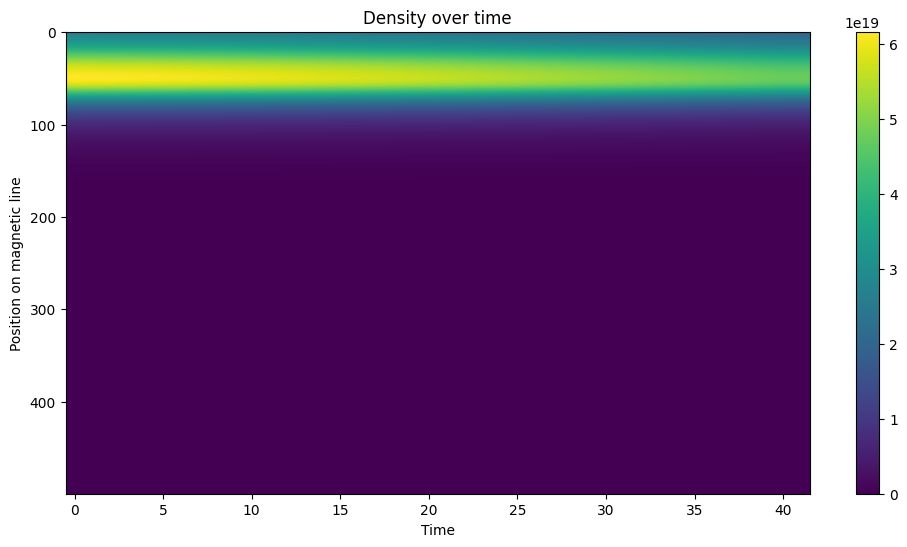

In [25]:
print("Plotting the density over time")
plot_1d_statistic_over_time(loaded_data["forcing"], 1, "2e forcing
                            ")

Plotting the velocity of the ions
(991, 500, 6)
(991, 500)


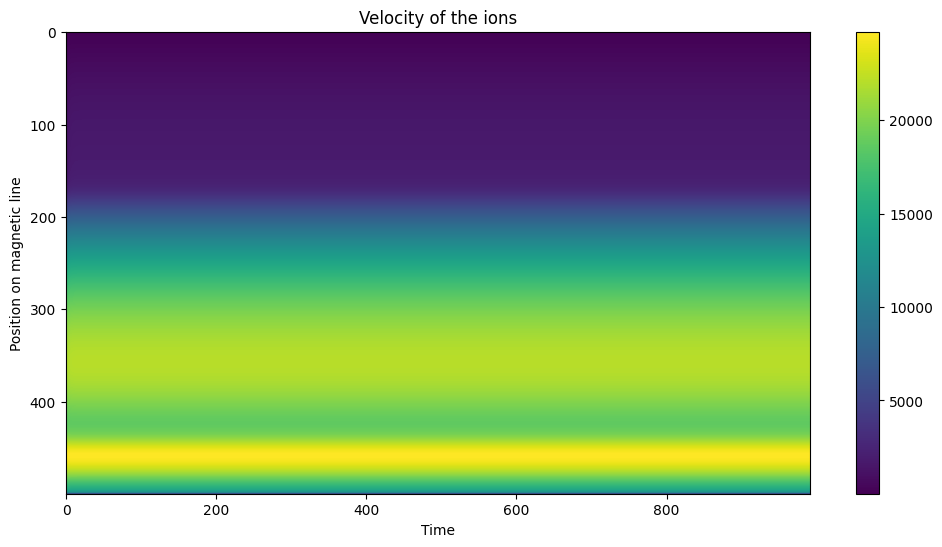

In [33]:
print("Plotting the velocity of the ions")
plot_1d_statistic_over_time(loaded_data["output"], 1, "Velocity of the ions")


Plotting the velocity of the atoms
(991, 500, 6)
(991, 500)


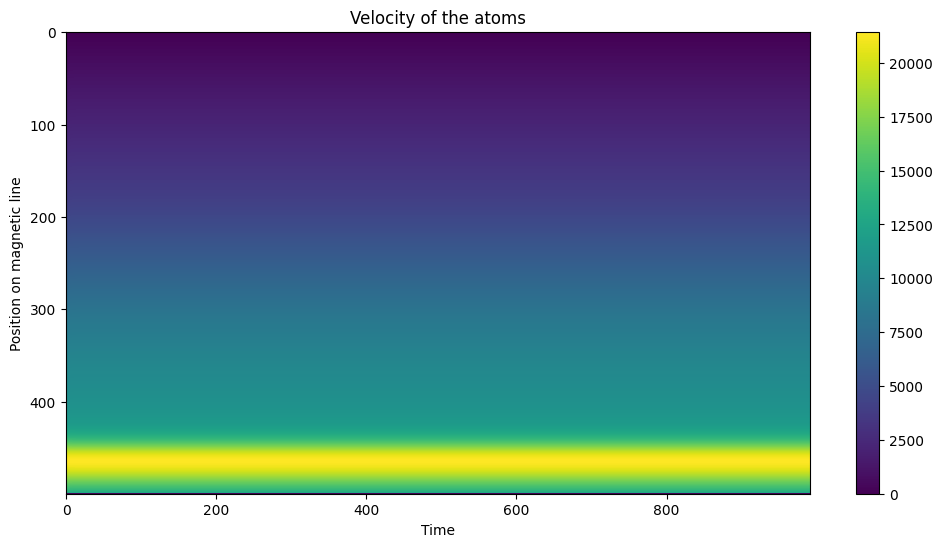

In [34]:
print("Plotting the velocity of the atoms")
plot_1d_statistic_over_time(loaded_data["output"], 2, "Velocity of the atoms")

Plotting the temperature over time
(991, 500, 6)
(991, 500)


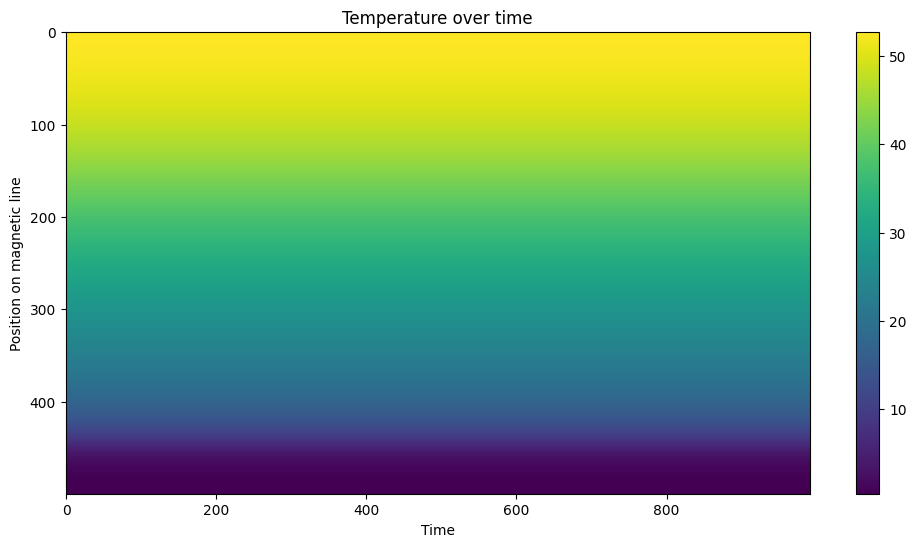

In [35]:
print("Plotting the temperature over time")
plot_1d_statistic_over_time(loaded_data["output"], 3, "Temperature over time")

Plotting the density of the atoms over time
(991, 500, 6)
(991, 500)


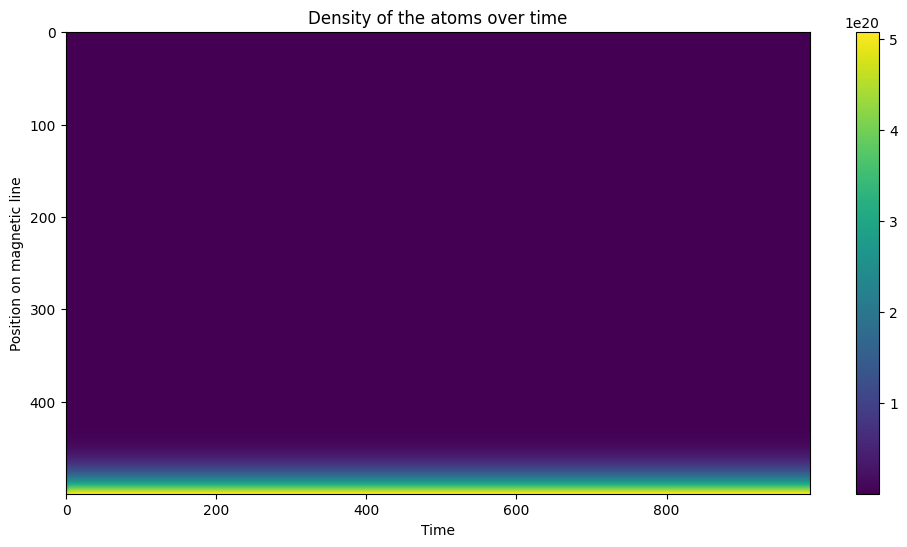

In [36]:
print("Plotting the density of the atoms over time")
plot_1d_statistic_over_time(loaded_data["output"], 4, "Density of the atoms over time")

Plotting the density of the molecules over time
(991, 500, 6)
(991, 500)


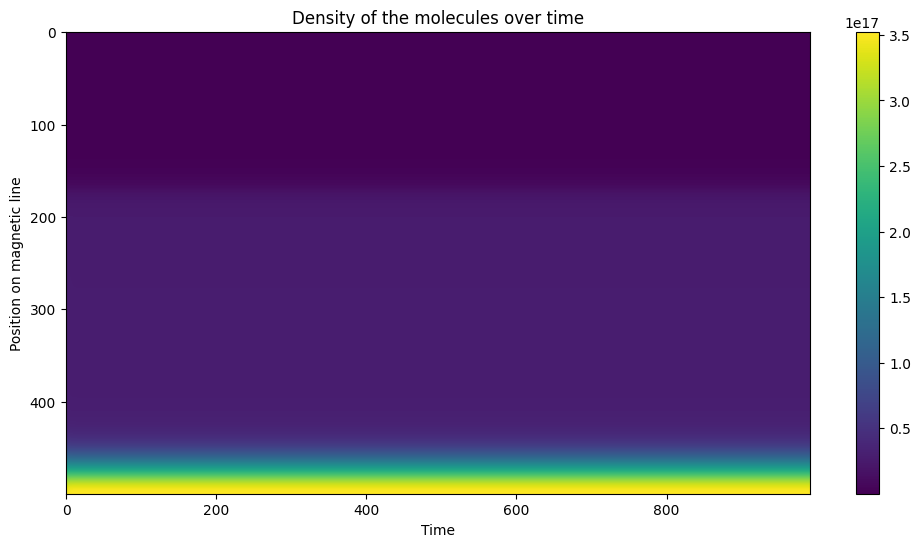

In [37]:
print("Plotting the density of the molecules over time")
plot_1d_statistic_over_time(loaded_data["output"], 5, "Density of the molecules over time")

Plotting the particle forcing over time
(991, 500, 2)
(991, 500)


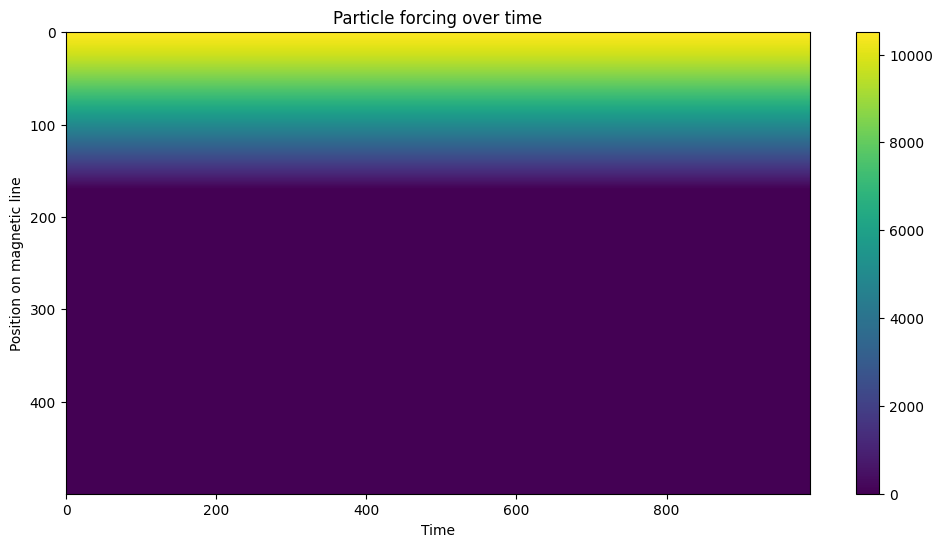

In [39]:
print("Plotting the particle forcing over time")
plot_1d_statistic_over_time(loaded_data["forcing"], 0, "Particle forcing over time")

Plotting the heat forcing over time
(991, 500, 2)
(991, 500)


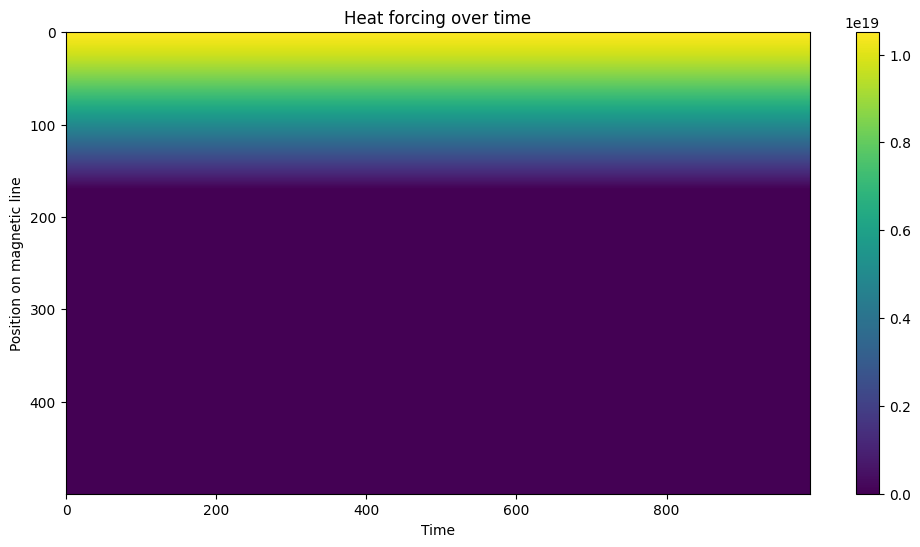

In [40]:
print("Plotting the heat forcing over time")
plot_1d_statistic_over_time(loaded_data["forcing"], 1, "Heat forcing over time")

### References
[1] Derks, G. L., Frankemölle, J. P. K. W., Koenders, J. T. W., van Berkel, M., Reimerdes, H., Wensing, M., & Westerhof, E. (2022). Benchmark of a self-consistent dynamic 1D divertor model DIV1D using the 2D SOLPS-ITER code. Plasma Physics and Controlled Fusion, 64(12), 125013.

The rest is up to you, good luck :)